In [26]:
import os

import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
%matplotlib inline

# pandas options
pd.set_option('mode.copy_on_write', True)  # pandas 2.0
pd.options.display.float_format = '{:.4f}'.format  # pd.reset_option('display.float_format')

# NumPy options
np.set_printoptions(precision = 2, suppress=True)  # suppress scientific notation

# 1. 데이터 불러오기

In [15]:
recomd = pd.read_csv('recommendations.csv')

In [3]:
recomd["user_id"].nunique() 

13781059

In [4]:
item_group = recomd.sort_values(by=['app_id','date'])

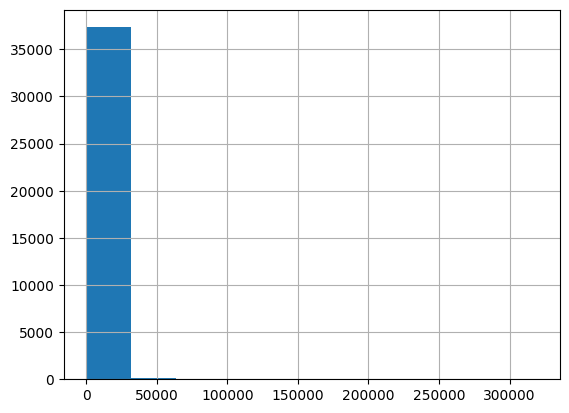

In [5]:
item_count = recomd.groupby('app_id').size().reset_index(name = 'count')
item_count['count'].hist()
plt.show()

In [6]:
# 상위 20% 아이템
threshold = item_count['count'].quantile(0.8)
print(f"임계값 (상위 20%): {threshold}")

임계값 (상위 20%): 274.0


In [7]:
# Old Items와 New Items 분리 - 상위 20% 기준으로
item_count['category'] = item_count['count'].apply(lambda x: 'Old' if x >= threshold else 'New')

old_items = item_count[item_count['category'] == 'Old']
new_items = item_count[item_count['category'] == 'New']

In [8]:
item_count['category'].value_counts()

category
New    30080
Old     7530
Name: count, dtype: int64

In [9]:
new_ids = new_items['app_id']
new_df  = item_group[item_group['app_id'].isin(new_ids)]

old_ids = old_items['app_id']
old_df = item_group[item_group['app_id'].isin(old_ids)]

In [14]:
# Grouped Data 생성
new_item_groups = new_df.groupby('app_id')

# 웜업 단계 크기 K 설정
K = 10

def split_group_safe(data, K):
    """
    데이터를 K 크기로 분리합니다.
    데이터가 부족하면 빈 DataFrame을 반환합니다.
    """
    warm_a = data.iloc[:K] if len(data) >= K else pd.DataFrame()
    warm_b = data.iloc[K:2*K] if len(data) >= 2*K else pd.DataFrame()
    warm_c = data.iloc[2*K:3*K] if len(data) >= 3*K else pd.DataFrame()
    test_set = data.iloc[3*K:] if len(data) > 3*K else pd.DataFrame()
    return warm_a, warm_b, warm_c, test_set

# 웜업 단계 분리 및 유효한 아이템 필터링
warmup_splits = {}

for item_id, item_data in tqdm(new_item_groups, desc="Processing New Items"):
    warm_a, warm_b, warm_c, test_set = split_group_safe(item_data, K)
    
    # 모든 세트에 데이터가 있는 경우에만 추가
    if all(not split.empty for split in [warm_a, warm_b, warm_c, test_set]):
        warmup_splits[item_id] = {
            'warm_a': warm_a,
            'warm_b': warm_b,
            'warm_c': warm_c,
            'test_set': test_set
        }


Processing New Items: 100%|██████████| 30080/30080 [00:15<00:00, 1889.67it/s]


In [15]:
# 단계별 데이터를 저장할 리스트
warm_a_list = []
warm_b_list = []
warm_c_list = []
test_set_list = []

# warmup_splits에서 데이터 추출
for item_id, splits in tqdm(warmup_splits.items(),desc='processing'):
    # 각 단계의 데이터를 추출하고 아이템 ID 추가
    warm_a = splits['warm_a'].copy()
    warm_a['stage'] = 'warm_a'
    warm_a_list.append(warm_a)

    warm_b = splits['warm_b'].copy()
    warm_b['stage'] = 'warm_b'
    warm_b_list.append(warm_b)

    warm_c = splits['warm_c'].copy()
    warm_c['stage'] = 'warm_c'
    warm_c_list.append(warm_c)

    test_set = splits['test_set'].copy()
    test_set['stage'] = 'test_set'
    test_set_list.append(test_set)

# 각각의 데이터프레임으로 병합
warm_a = pd.concat(warm_a_list, ignore_index=True)
warm_b = pd.concat(warm_b_list, ignore_index=True)
warm_c = pd.concat(warm_c_list, ignore_index=True)
test_set = pd.concat(test_set_list, ignore_index=True)


processing: 100%|██████████| 13249/13249 [00:17<00:00, 764.80it/s] 


In [16]:
print("Old DataFrame")
print("총 데이터 개수:", len(old_df))
print("고유 app_id 개수:", old_df['app_id'].nunique())
print("고유 user_id 개수:", old_df['user_id'].nunique())
print("-" * 40)

print("Warm A")
print("총 데이터 개수:", len(warm_a))
print("고유 app_id 개수:", warm_a['app_id'].nunique())
print("고유 user_id 개수:", warm_a['user_id'].nunique())
print("-" * 40)

print("Warm B")
print("총 데이터 개수:", len(warm_b))
print("고유 app_id 개수:", warm_b['app_id'].nunique())
print("고유 user_id 개수:", warm_b['user_id'].nunique())
print("-" * 40)

print("Warm C")
print("총 데이터 개수:", len(warm_c))
print("고유 app_id 개수:", warm_c['app_id'].nunique())
print("고유 user_id 개수:", warm_c['user_id'].nunique())
print("-" * 40)

print("Test Set")
print("총 데이터 개수:", len(test_set))
print("고유 app_id 개수:", test_set['app_id'].nunique())
print("고유 user_id 개수:", test_set['user_id'].nunique())
print("-" * 40)


Old DataFrame
총 데이터 개수: 39639864
고유 app_id 개수: 7530
고유 user_id 개수: 13670645
----------------------------------------
Warm A
총 데이터 개수: 132490
고유 app_id 개수: 13249
고유 user_id 개수: 86204
----------------------------------------
Warm B
총 데이터 개수: 132490
고유 app_id 개수: 13249
고유 user_id 개수: 93580
----------------------------------------
Warm C
총 데이터 개수: 132490
고유 app_id 개수: 13249
고유 user_id 개수: 95731
----------------------------------------
Test Set
총 데이터 개수: 894438
고유 app_id 개수: 13249
고유 user_id 개수: 500296
----------------------------------------


---

In [44]:
df_steam = recomd

In [45]:
df_steam['interaction'] = df_steam['is_recommended'].astype(int)

In [46]:
df_steam['interaction'].value_counts()

interaction
1    35304398
0     5850396
Name: count, dtype: int64

In [47]:
# define unique function
def _unique(sample, fname):
    tmp_df = pd.DataFrame()
    tmp_df[fname] = sample[fname].unique()
    num = len(tmp_df)
    tmp_df['tmp_feature'] = range(num)
    sample = sample.join(tmp_df.set_index(fname), on=fname)
    sample.drop(fname, axis=1, inplace=True)
    sample = sample.rename(columns = {"tmp_feature": fname})
    return num, sample

num_user, df_steam = _unique(df_steam, 'user_id')
num_app, df_steam = _unique(df_steam, 'app_id')

description = [
    ('user_id', num_user, 'spr'),  # 변환된 유저 ID
    ('app_id', num_app, 'spr'),  # 변환된 게임(아이템) ID
    ('date', -1, 'ctn'),  # 정규화된 날짜
    ('interaction', 2, 'label')  # 클릭 여부
]
description


[('user_id', 13781059, 'spr'),
 ('app_id', 37610, 'spr'),
 ('date', -1, 'ctn'),
 ('interaction', 2, 'label')]

In [48]:
df_steam['date'] = pd.to_datetime(df_steam['date'])
df_steam['date'] = (df_steam['date'] - pd.Timestamp("1970-01-01")).dt.days
min_date = np.min(df_steam['date'])
max_date = np.max(df_steam['date'])

df_steam['date'] = df_steam['date'].map(lambda x: (x - min_date) / (max_date - min_date))
df_steam = df_steam.sort_values(by='date')  # 시간순 정렬


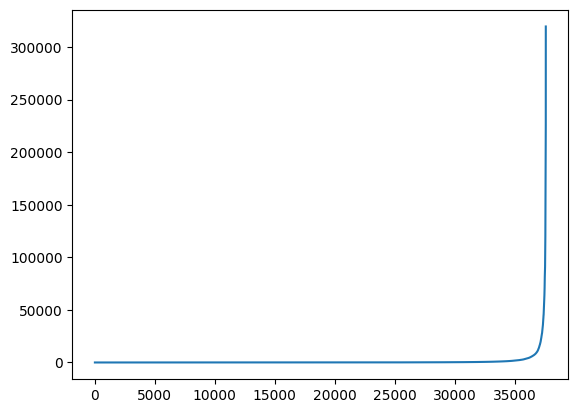

In [49]:
# plot item counts vs item
user2count = df_steam.groupby(['app_id']).size().reset_index(name='count').sort_values(by='count')
item_ids = list(user2count['app_id'])
counts = np.array(user2count['count'])
plt.plot(np.arange(len(counts)), counts)

In [50]:
def split_2(df_ratings, description, N=274, K=10):
    user2count = df_ratings.groupby(['app_id']).size().reset_index(name='count').sort_values(by='count')
    item_ids = user2count['app_id'].to_numpy()
    counts = user2count['count'].to_numpy()

    hot_item_ids = item_ids[counts > N]
    cold_item_ids = item_ids[(counts <= N) & (counts >= 3 * K)]

    item_group = df_ratings.groupby('app_id')

    train_base_list = []
    for item_id in hot_item_ids:
        df_hot = item_group.get_group(item_id).sort_values(by='date')
        train_base_list.append(df_hot)

    train_base = pd.concat(train_base_list, ignore_index=True)

    train_warm_a_list, train_warm_b_list, train_warm_c_list, test_list = [], [], [], []
    
    for item_id in cold_item_ids:
        df_cold = item_group.get_group(item_id).sort_values(by='date')
        train_warm_a_list.append(df_cold[:K])
        train_warm_b_list.append(df_cold[K:2*K])
        train_warm_c_list.append(df_cold[2*K:3*K])
        test_list.append(df_cold[3*K:])
    
    train_warm_a = pd.concat(train_warm_a_list, ignore_index=True)
    train_warm_b = pd.concat(train_warm_b_list, ignore_index=True)
    train_warm_c = pd.concat(train_warm_c_list, ignore_index=True)
    test = pd.concat(test_list, ignore_index=True)

    save_dic = {
        'train_base': train_base.sort_values('date'),
        'train_warm_a': train_warm_a.sort_values('date'),
        'train_warm_b': train_warm_b.sort_values('date'),
        'train_warm_c': train_warm_c.sort_values('date'),
        'test': test.sort_values('date'),
        'description': description
    }

    for name, df in save_dic.items():
        print("{} size: {}".format(name, len(df)))

    with open('./emb_warm_split_preprocess.pkl', 'bw+') as f:
        pickle.dump(save_dic, f)


In [51]:
split_2(df_steam, description)

train_base size: 39636576
train_warm_a size: 135630
train_warm_b size: 135630
train_warm_c size: 135630
test size: 897366
description size: 4


In [52]:
# Get training data for Meta-Embedding method
with open('./emb_warm_split_preprocess.pkl', 'rb') as f:
    data = pickle.load(f)

df_base = data['train_base']
item2group = df_base.groupby('app_id')

train_a_list, train_b_list, train_c_list, train_d_list = [], [], [], []

for item_id, df_group in item2group:
    l, e = df_group.shape[0], df_group.shape[0] // 4     
    train_a_list.append(df_group.iloc[0:e])
    train_b_list.append(df_group.iloc[e: 2 * e])
    train_c_list.append(df_group.iloc[2 * e: 3 * e])
    train_d_list.append(df_group.iloc[3 * e: 4 * e]) 

train_a = pd.concat(train_a_list, ignore_index=True)
train_b = pd.concat(train_b_list, ignore_index=True)
train_c = pd.concat(train_c_list, ignore_index=True)
train_d = pd.concat(train_d_list, ignore_index=True)

shuffle_idx = np.random.permutation(train_a.shape[0])
train_a = train_a.iloc[shuffle_idx]
train_b = train_b.iloc[shuffle_idx]
train_c = train_c.iloc[shuffle_idx]
train_d = train_d.iloc[shuffle_idx]

data["metaE_a"] = train_a
data["metaE_b"] = train_b
data["metaE_c"] = train_c
data["metaE_d"] = train_d

with open('./Steam_data.pkl', 'wb') as f:
    pickle.dump(data, f)


In [53]:
print("데이터 타입:", type(data))
print("데이터 크기:", len(data) if isinstance(data, dict) else "Not a dict")
print("데이터 키 목록:", data.keys() if isinstance(data, dict) else "Not a dict")


데이터 타입: <class 'dict'>
데이터 크기: 10
데이터 키 목록: dict_keys(['train_base', 'train_warm_a', 'train_warm_b', 'train_warm_c', 'test', 'description', 'metaE_a', 'metaE_b', 'metaE_c', 'metaE_d'])
